In [16]:
# 02_model_baselines.ipynb
# Train baseline models on the processed UCI diabetes cohort

import sys
import os
import numpy as np
import pandas as pd

repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

from src.train import split_data
from src.models_baseline import train_logreg, train_logreg_l1
import matplotlib.pyplot as plt

PROCESSED_PATH = "../data_processed/admissions_features.csv"

df = pd.read_csv(PROCESSED_PATH)
print("Shape:", df.shape)
df.head()

Shape: (25000, 64)


,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,on_diabetes_med,med_up,med_down,...,diag_3_Respiratory,diag_3_nan,glucose_test_high,glucose_test_no,glucose_test_normal,glucose_test_nan,A1Ctest_high,A1Ctest_no,A1Ctest_normal,A1Ctest_nan
0,8,72,1,18,2,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1,3,34,2,13,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
2,5,45,0,18,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
3,2,36,0,12,1,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,42,0,7,0,0,0,0,0,0,...,True,False,False,True,False,False,False,True,False,False


In [17]:
label_col = "label"

cols_to_drop = [label_col, "encounter_id", "patient_nbr"]
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

X = df.drop(columns=cols_to_drop)
y = df[label_col]

print("Shape:", X.shape)
print("Positive rate:", y.mean())

Shape: (25000, 63)
Positive rate: 0.47016


In [18]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, label_col=label_col)

# Make sure we dropped ID columns from all splits
drop_cols = ["encounter_id", "patient_nbr", label_col]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_val   = X_val.drop(columns=[c for c in drop_cols if c in X_val.columns])
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

X_train.shape, X_val.shape, X_test.shape

((17500, 63), (3750, 63), (3750, 63))

In [19]:
def eval_model(model, X, y, set_name="val"):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[:, 1]
    else:
        # fallback: use decision_function then squish
        scores = model.decision_function(X)
        # simple min-max scale as pseudo-prob
        probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)

    preds = (probs >= 0.5).astype(int)

    metrics = {
        "set": set_name,
        "AUROC": roc_auc_score(y, probs),
        "AUPRC": average_precision_score(y, probs),
        "Accuracy": accuracy_score(y, preds),
    }
    return metrics, preds, probs

In [20]:
logreg = train_logreg(X_train, y_train)
logreg_l1 = train_logreg_l1(X_train, y_train)
logreg_metrics_val, logreg_preds_val, logreg_probs_val = eval_model(
    logreg, X_val, y_val, "val"
)
logreg_metrics_test, logreg_preds_test, logreg_probs_test = eval_model(
    logreg, X_test, y_test, "test"
)

logreg_l1_metrics_val, logreg_l1_preds_val, logreg_l1_probs_val = eval_model(
    logreg_l1, X_val, y_val, "val"
)
logreg_l1_metrics_test, logreg_l1_preds_test, logreg_l1_probs_test = eval_model(
    logreg_l1, X_test, y_test, "test"
)

logreg_metrics_val, logreg_metrics_test

({'set': 'val',
  'AUROC': 0.6550527949539277,
  'AUPRC': 0.6271755761235982,
  'Accuracy': 0.6176},
 {'set': 'test',
  'AUROC': 0.6411401848829645,
  'AUPRC': 0.6232955577560453,
  'Accuracy': 0.6144})

In [21]:
results_val = pd.DataFrame([
    {"model": "LogReg_L2", **logreg_metrics_val},
    {"model": "LogReg_L1", **logreg_l1_metrics_val},
]).set_index("model")

results_test = pd.DataFrame([
    {"model": "LogReg_L2", **logreg_metrics_test},
    {"model": "LogReg_L1", **logreg_l1_metrics_test},
]).set_index("model")

print("Validation:")
display(results_val)

print("\nTest:")
display(results_test)

Validation:


,set,AUROC,AUPRC,Accuracy
model,,,,
LogReg_L2,val,0.655053,0.627176,0.6176
LogReg_L1,val,0.655057,0.627166,0.6168



Test:


,set,AUROC,AUPRC,Accuracy
model,,,,
LogReg_L2,test,0.641140,0.623296,0.6144
LogReg_L1,test,0.641156,0.623343,0.6136


Confusion matrix (test, L2 Logistic Regression):
[[1442  545]
 [ 901  862]]


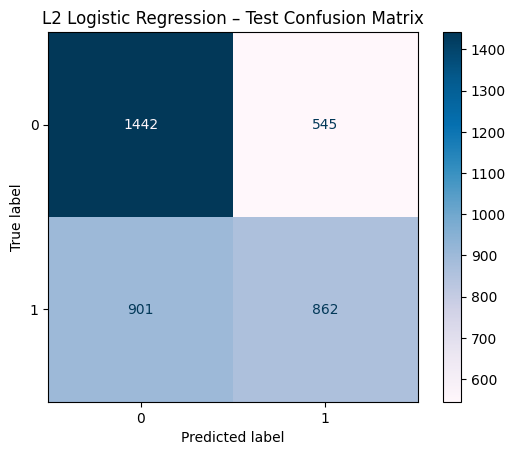

Classification report (test, L2 Logistic Regression):
              precision    recall  f1-score   support

           0      0.615     0.726     0.666      1987
           1      0.613     0.489     0.544      1763

    accuracy                          0.614      3750
   macro avg      0.614     0.607     0.605      3750
weighted avg      0.614     0.614     0.609      3750



In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test_preds = logreg_preds_test
test_labels = y_test

cm = confusion_matrix(test_labels, test_preds)
print("Confusion matrix (test, L2 Logistic Regression):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="PuBu")
plt.title("L2 Logistic Regression – Test Confusion Matrix")
plt.show()

print("Classification report (test, L2 Logistic Regression):")
print(classification_report(test_labels, test_preds, digits=3))

Confusion matrix (test, L1 Logistic Regression):
[[1446  541]
 [ 908  855]]


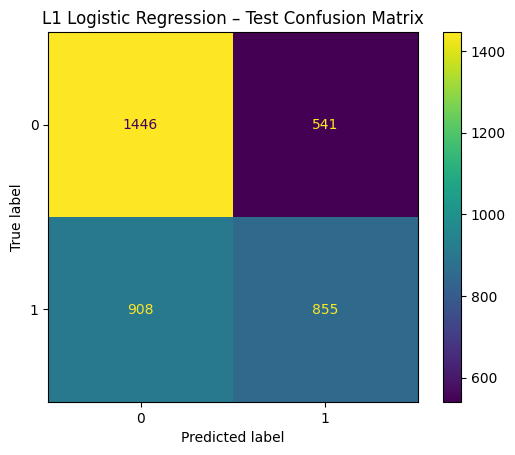

Classification report (test, L1 Logistic Regression):
              precision    recall  f1-score   support

           0      0.614     0.728     0.666      1987
           1      0.612     0.485     0.541      1763

    accuracy                          0.614      3750
   macro avg      0.613     0.606     0.604      3750
weighted avg      0.613     0.614     0.607      3750



In [23]:
cm_l1 = confusion_matrix(y_test, logreg_l1_preds_test)
print("Confusion matrix (test, L1 Logistic Regression):")
print(cm_l1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_l1, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("L1 Logistic Regression – Test Confusion Matrix")
plt.show()

print("Classification report (test, L1 Logistic Regression):")
print(classification_report(y_test, logreg_l1_preds_test, digits=3))

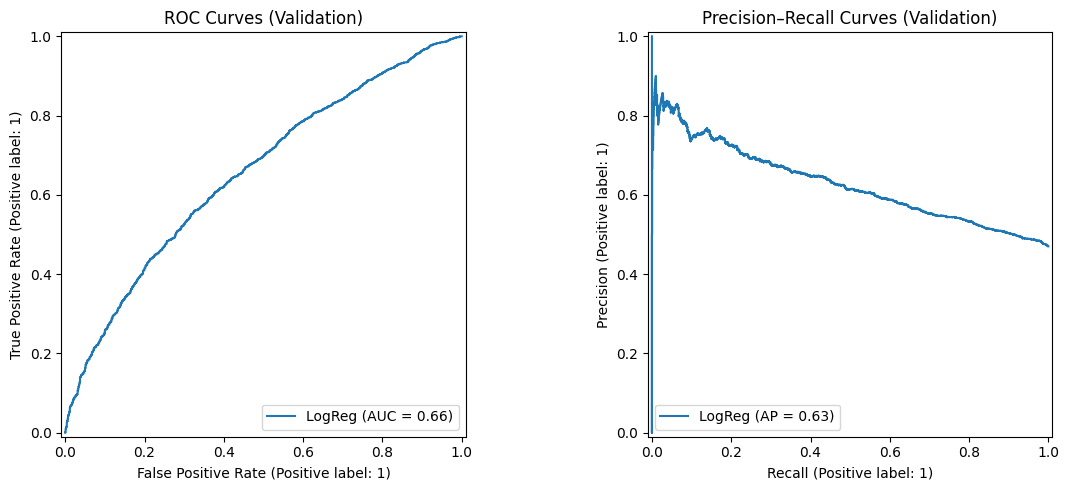

In [24]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_val, logreg_probs_val, ax=axes[0], name="LogReg")
axes[0].set_title("ROC Curves (Validation)")

PrecisionRecallDisplay.from_predictions(y_val, logreg_probs_val, ax=axes[1], name="LogReg")
axes[1].set_title("Precision–Recall Curves (Validation)")

plt.tight_layout()
plt.show()